In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Đọc dữ liệu (đặt file Mall_Customers.csv cùng thư mục với file .py hoặc notebook)
df = pd.read_csv('Mall_Customers.csv')

# Đổi tên cột cho dễ dùng
df.rename(columns={'Annual Income (k$)': 'Income', 'Spending Score (1-100)': 'Spending'}, inplace=True)

print(df.head())
print(df.shape)  # (200, 5) → thực tế có 200 khách hàng (vẫn đủ lớn để demo)

   CustomerID  Gender  Age  Income  Spending
0           1    Male   19      15        39
1           2    Male   21      15        81
2           3  Female   20      16         6
3           4  Female   23      16        77
4           5  Female   31      17        40
(200, 5)


### =======Ví dụ 1: Phân khúc khách hàng chỉ dùng 2 đặc trưng Income & Spending=======

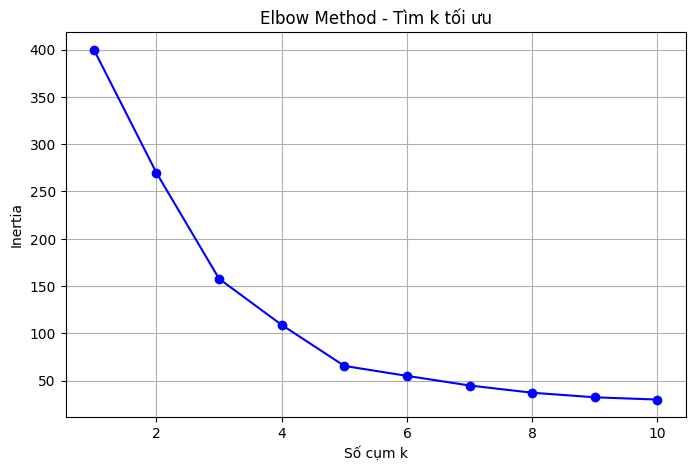

In [ ]:
# Chọn 2 cột quan trọng nhất
X1 = df[['Income', 'Spending']]

# Chuẩn hóa dữ liệu (rất quan trọng với K-Means)
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# Dùng Elbow Method tìm k tối ưu
inertias = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #_init=10 Số lần chạy lại toàn bộ thuật toán K-Means với các bộ khởi tạo ngẫu nhiên khác nhau.
    kmeans.fit(X1_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Số cụm k')
plt.ylabel('Inertia')
plt.title('Elbow Method - Tìm k tối ưu')
plt.grid(True)
plt.show()

```bash
Từ k=1 → k=2: Inertia giảm rất mạnh
Từ k=2 → k=3 → k=4: vẫn giảm khá mạnh
Từ k=5 trở đi: đường cong bắt đầu “phẳng dần” → giảm không còn đáng kể nữa
→ Điểm khuỷu tay (elbow point) rõ nhất là k=5
```

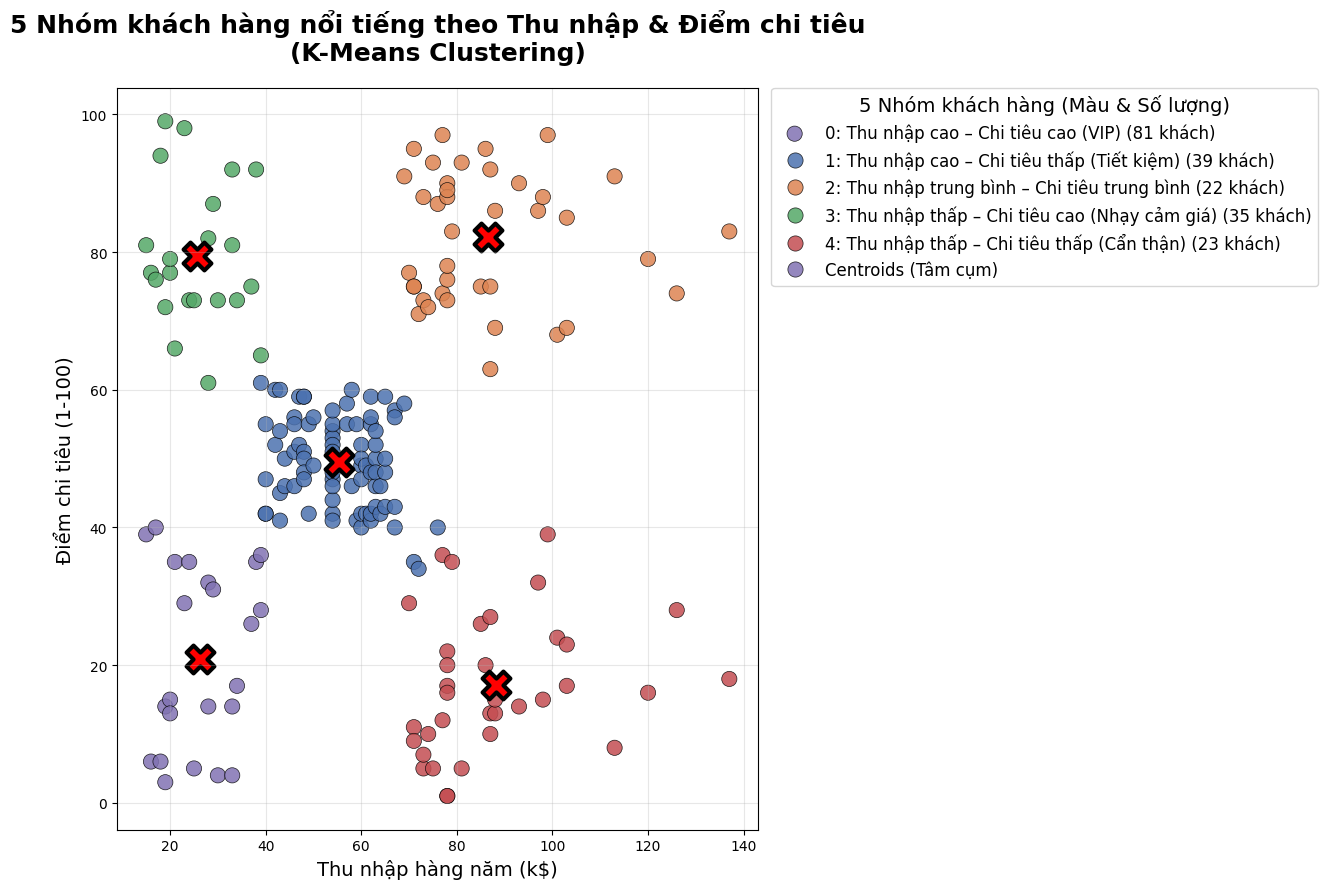

TÓM TẮT 5 NHÓM KHÁCH HÀNG
                                             Thu nhập TB (k$)  Chi tiêu TB  \
Tên nhóm                                                                     
Thu nhập thấp – Chi tiêu cao (Nhạy cảm giá)              88.2         17.1   
Thu nhập cao – Chi tiêu thấp (Tiết kiệm)                 86.5         82.1   
Thu nhập cao – Chi tiêu cao (VIP)                        55.3         49.5   
Thu nhập thấp – Chi tiêu thấp (Cẩn thận)                 26.3         20.9   
Thu nhập trung bình – Chi tiêu trung bình                25.7         79.4   

                                             Số lượng khách  
Tên nhóm                                                     
Thu nhập thấp – Chi tiêu cao (Nhạy cảm giá)              35  
Thu nhập cao – Chi tiêu thấp (Tiết kiệm)                 39  
Thu nhập cao – Chi tiêu cao (VIP)                        81  
Thu nhập thấp – Chi tiêu thấp (Cẩn thận)                 23  
Thu nhập trung bình – Chi tiêu trung bình              

In [23]:
# Áp dụng K-Means (k=5)
kmeans1 = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Cluster_Income_Spending'] = kmeans1.fit_predict(X1_scaled)

# Đặt tên nhóm đẹp (theo thứ tự chuẩn của dataset này)
cluster_names = {
    0: 'Thu nhập cao – Chi tiêu cao (VIP)',
    1: 'Thu nhập cao – Chi tiêu thấp (Tiết kiệm)',
    2: 'Thu nhập trung bình – Chi tiêu trung bình',
    3: 'Thu nhập thấp – Chi tiêu cao (Nhạy cảm giá)',
    4: 'Thu nhập thấp – Chi tiêu thấp (Cẩn thận)'
}
df['Tên nhóm'] = df['Cluster_Income_Spending'].map(cluster_names)

# Tính số lượng khách mỗi nhóm để hiện trong legend
cluster_counts = df['Cluster_Income_Spending'].value_counts().sort_index()
labels_with_count = [f"{i}: {cluster_names[i]} ({cluster_counts[i]} khách)" 
                    for i in range(5)]

# Vẽ biểu đồ siêu đẹp + legend đầy đủ thông tin
plt.figure(figsize=(13, 9))
sns.scatterplot(data=df, x='Income', y='Spending', 
                hue='Cluster_Income_Spending',
                palette='deep', 
                s=120, 
                alpha=0.85,
                edgecolor='k', 
                linewidth=0.5)

# Vẽ centroids
centroids_original = scaler.inverse_transform(kmeans1.cluster_centers_)
plt.scatter(centroids_original[:, 0], centroids_original[:, 1],
            s=400, c='red', marker='X', edgecolor='black', linewidth=3, label='Centroids')

# Tùy chỉnh legend
plt.legend(title='5 Nhóm khách hàng (Màu & Số lượng)',
           labels=labels_with_count + ['Centroids (Tâm cụm)'],
           title_fontsize=14,
           fontsize=12,
           loc='upper left',
           bbox_to_anchor=(1.02, 1),  # đặt legend ra ngoài bên phải
           borderaxespad=0)

plt.title('5 Nhóm khách hàng nổi tiếng theo Thu nhập & Điểm chi tiêu\n(K-Means Clustering)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Thu nhập hàng năm (k$)', fontsize=14)
plt.ylabel('Điểm chi tiêu (1-100)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# In bảng tóm tắt để dán vào báo cáo
print("="*70)
print("TÓM TẮT 5 NHÓM KHÁCH HÀNG")
print("="*70)
summary = df.groupby('Tên nhóm').agg({
    'Income': 'mean',
    'Spending': 'mean',
    'CustomerID': 'count'
}).round(1).sort_values(by='Income', ascending=False)
summary.columns = ['Thu nhập TB (k$)', 'Chi tiêu TB', 'Số lượng khách']
print(summary)

### =======Ví dụ 2: Phân cụm khách hàng dựa trên Age (Tuổi) và Spending (Điểm chi ti=======

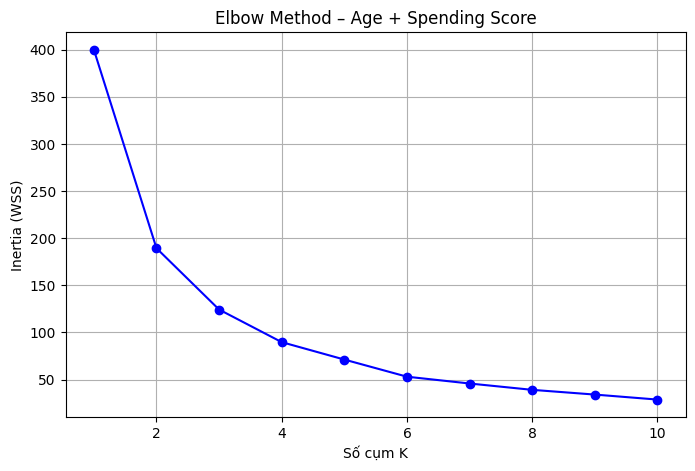

In [37]:
# Code tính Elbow cho ví dụ 2
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X2_scaled)        # X2_scaled = Age + Spending đã chuẩn hóa
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Số cụm K')
plt.ylabel('Inertia (WSS)')
plt.title('Elbow Method – Age + Spending Score')
plt.grid(True)
plt.show()

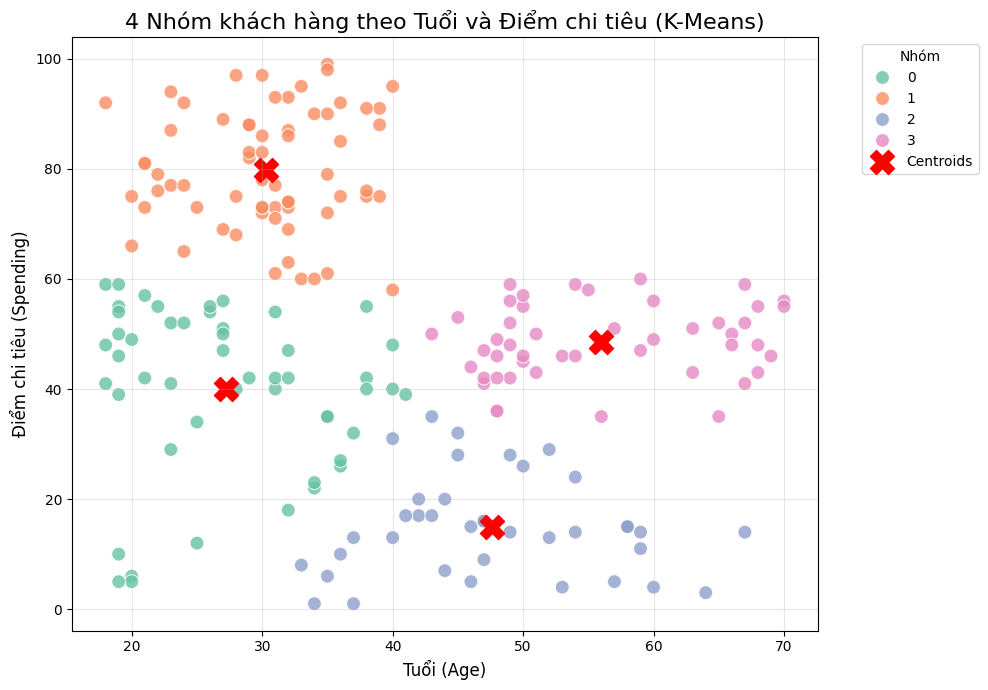

TÓM TẮT 4 NHÓM KHÁCH HÀNG (Ví dụ 2)
                                       Tuổi TB  Chi tiêu TB  Số lượng khách
Tên nhóm 2                                                                 
Tuổi trung niên – Chi tiêu trung bình     27.2         40.0              50
Tuổi trẻ – Chi tiêu cao                   30.3         79.8              65
Tuổi cao – Chi tiêu thấp                  47.6         15.0              38
Tuổi trung bình – Chi tiêu thấp           56.0         48.5              47


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Đọc dữ liệu
df = pd.read_csv('Mall_Customers.csv')
df.rename(columns={'Annual Income (k$)': 'Income', 'Spending Score (1-100)': 'Spending'}, inplace=True)

# Chọn 2 đặc trưng cho ví dụ 2: Age và Spending
X2 = df[['Age', 'Spending']]
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

# Áp dụng K-Means với K=4
kmeans2 = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster_Age_Spending'] = kmeans2.fit_predict(X2_scaled)

# Đặt tên nhóm đơn giản (dựa trên phân tích cụm)
cluster_names = {
    0: 'Tuổi trung niên – Chi tiêu trung bình',
    1: 'Tuổi trẻ – Chi tiêu cao',
    2: 'Tuổi cao – Chi tiêu thấp',
    3: 'Tuổi trung bình – Chi tiêu thấp'
}
df['Tên nhóm 2'] = df['Cluster_Age_Spending'].map(cluster_names)

# Vẽ biểu đồ scatter plot để trực quan
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Age', y='Spending', 
                hue='Cluster_Age_Spending', palette='Set2', s=100, alpha=0.8)

# Vẽ centroids (tâm cụm)
centroids_original = scaler.inverse_transform(kmeans2.cluster_centers_)
plt.scatter(centroids_original[:, 0], centroids_original[:, 1],
            s=300, c='red', marker='X', label='Centroids')

plt.title('4 Nhóm khách hàng theo Tuổi và Điểm chi tiêu (K-Means)', fontsize=16)
plt.xlabel('Tuổi (Age)', fontsize=12)
plt.ylabel('Điểm chi tiêu (Spending)', fontsize=12)
plt.legend(title='Nhóm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tóm tắt thống kê
summary2 = df.groupby('Tên nhóm 2').agg({
    'Age': 'mean',
    'Spending': 'mean',
    'CustomerID': 'count'
}).round(1).sort_values(by='Age')
summary2.columns = ['Tuổi TB', 'Chi tiêu TB', 'Số lượng khách']
print("TÓM TẮT 4 NHÓM KHÁCH HÀNG (Ví dụ 2)")
print(summary2)